In [ ]:
import cv2
import numpy as np

In [ ]:
from IPython.display import Image, display

In [ ]:
image_path = '/content/sample_data/882.jpg'
image = cv2.imread(image_path)

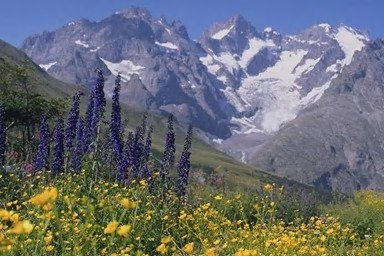

In [ ]:
display(Image(image_path))

In [ ]:
# Blur the image
blurred_image = cv2.blur(image, (3, 3))

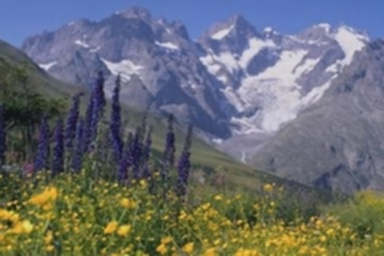

In [ ]:
blurred_image_path = '/content/sample_data/882_blur.jpg'
cv2.imwrite(blurred_image_path, blurred_image)
display(Image(blurred_image_path))

In [ ]:
def quantize_pixel(pixel, n_colours):
    k = int(n_colours ** (1/3))
    factor = int(256 / k)
    return [int(pixel[0]/factor), int(pixel[1]/factor), int(pixel[2]/factor)]

def get_color_number_from_pixel(pixel, n_colours):
    k = int(n_colours ** (1/3))
    return k * k * pixel[0] + k * pixel[1] + pixel[2]

def convert_quantized_image_to_visualize(quantized_img, n_colours):
    k = int(n_colours ** (1/3))
    factor = int(256 / k)
    final_image = []
    for pixel in quantized_img.reshape(-1, 3):
        final_image.append([int(pixel[0] * factor), int(pixel[1] * factor), int(pixel[2] * factor)])
    final_image_np = np.asarray(final_image)
    final_image_np = final_image_np.reshape(quantized_img.shape)
    return final_image_np

def get_preprocessed_image(image_path, n_colours):
    image = cv2.imread(image_path)
    # Blur the image
    blurred_image = cv2.blur(image, (3, 3))
    quantized_image = []
    for pixel in blurred_image.reshape(-1, 3):
        quantized_image.append(quantize_pixel(pixel, n_colours))
    quantized_image_np = np.asarray(quantized_image)
    quantized_image_np = quantized_image_np.reshape(image.shape)
    return quantized_image_np

In [93]:
def get_colour_mask_from_quantized_image(quantized_image, n_colours):
    color_mask = []
    for pixel in quantized_image.reshape(-1, 3):
        color_mask.append(get_color_number_from_pixel(pixel, n_colours))
    return np.asarray(color_mask)

In [107]:
def get_ccv_from_quantized_image(image_path, n_colours, tau):
    quantized_image = get_preprocessed_image(image_path, n_colours)
    # Initialize coherence vector
    ccv_vector = []
    # Get color mask from quantized image
    colour_mask = get_colour_mask_from_quantized_image(quantized_image, n_colours)
    shaped_colour_mask = colour_mask.reshape(quantized_image.shape[0], quantized_image.shape[1])

    # Iterate over each discretized color
    for i in range(n_colours):
        # Extract pixels with the current color
        binary_mask = (shaped_colour_mask == i).astype(np.uint8)
        # Find connected components
        _, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=4)
        # Initialize coherence pair
        alpha_j, beta_j = 0, 0
        # Iterate over connected components
        for j in range(1, stats.shape[0]):
            component_size = stats[j, cv2.CC_STAT_AREA]
            # Classify pixels as coherent or incoherent based on the size
            if component_size > tau:
                alpha_j += component_size
            else:
                beta_j += component_size
        # Add coherence pair to the vector
        ccv_vector.append(alpha_j)
        ccv_vector.append(beta_j)
    return np.asarray(ccv_vector)

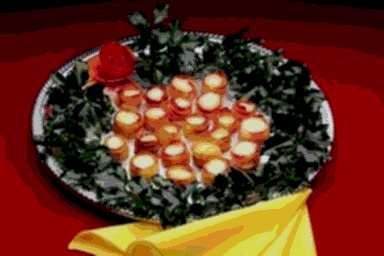

In [136]:
image_path = '/content/sample_data/994.jpg'
channel_bins = 8
n_colours = channel_bins ** 3
quantized_image_np = get_preprocessed_image(image_path, n_colours)
quantized_image_path = '/content/sample_data/882_quantized_' + str(n_colours) + '.jpg'
cv2.imwrite(quantized_image_path, convert_quantized_image_to_visualize(quantized_image_np, n_colours))
display(Image(quantized_image_path))

In [137]:
image_path = '/content/sample_data/882.jpg'
channel_bins = 8
n_colours = channel_bins ** 3
ccv_vector = get_ccv_from_quantized_image(image_path, n_colours, 300)

In [138]:
ccv_vector.shape

(1024,)

In [139]:
ccv_vector.sum()

98304